In [13]:
from itertools import combinations

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [82]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 01

This chapter introduces the concept of causality and highlights similarities and differences between causal inference and statistical learning. A brief historical outline of the concept of causality is provided to help the reader understand a broader context. Finally, three motivating examples are provided (medicine, marketing, social policy) to demonstrate the importance of causal inference in terms of technical, practical and business perspectives. 

## Confounding

In [14]:
# Let's set random seed for reproducibility
np.random.seed(45)

# `b` represents our confounder
b = np.random.rand(100)

# `a` and `c` are causally independent of each other, but they are both children of `b` 
a = b + .1 * np.random.rand(100)
c = b + .3 * np.random.rand(100)

In [15]:
# Let's check correlation between `a` and `c`
coef, p_val = stats.pearsonr(a, c)

print(coef)
print("{0:.2f}".format(coef))

0.9627497625297514
0.96


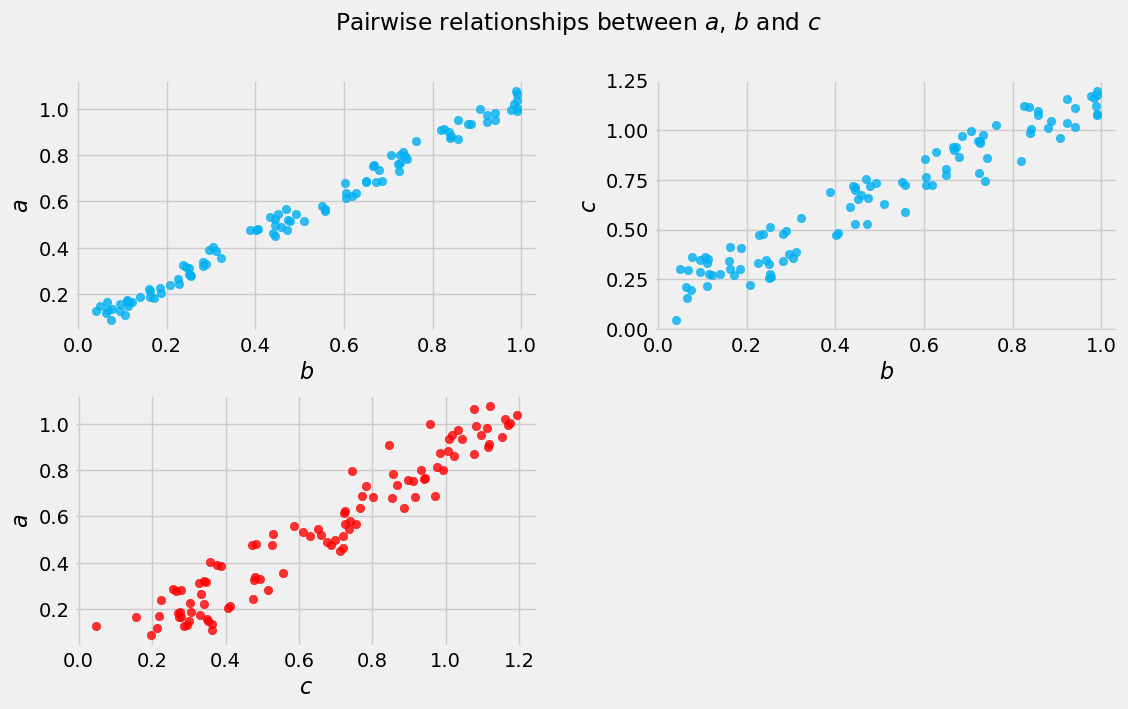

In [16]:
variables = {
    'a': a,
    'b': b,
    'c': c
}

plt.figure(figsize=(12, 7))

for i, (var_1, var_2) in enumerate([('b', 'a'), ('b', 'c'), ('c', 'a')]):
    
    color = COLORS[1]
    
    if 'b' in [var_1, var_2]:
        color = COLORS[0]
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(variables[var_1], variables[var_2], alpha=.8, color=color)
    
    plt.xlabel(f'${var_1}$', fontsize=16)
    plt.ylabel(f'${var_2}$', fontsize=16)

plt.suptitle('Pairwise relationships between $a$, $b$ and $c$')
plt.subplots_adjust(hspace=.25, wspace=.25)
plt.show()

# Chapter 02

This chapter introduces the concept of “the ladder of causation”. We focus on highlighting differences between two main concepts: associations and interventions. 

## Association

### Bookstore example

In [64]:
# First, we'll build a structural causal model (SCM)
class BookSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()
        self.u_1 = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        a = u_0 > .61
        b = (a + .5 * u_1) > .2
        
        return a, b

In [65]:
# Let's initialize our SCM
scm = BookSCM(random_seed=45)

In [66]:
# ...and sample from it
buy_book_a, buy_book_b = scm.sample(100)

In [67]:
# Sanity check
buy_book_a.shape, buy_book_b.shape

((100,), (100,))

In [68]:
# Let's compute probabilities
proba_book_a = buy_book_a.sum() / buy_book_a.shape[0]
proba_book_b = buy_book_b.sum() / buy_book_b.shape[0]

print(f'Probability of buying book A: {proba_book_a:0.3f}')
print(f'Probability of buying book B: {proba_book_b:0.3f}')

# ...and conditional probailities
proba_book_a_given_book_b = np.where(buy_book_b, buy_book_a, 0).sum() / buy_book_b.sum()
proba_book_b_given_book_a = np.where(buy_book_a, buy_book_b, 0).sum() / buy_book_a.sum()

print(f'Probability of buying book A given B: {proba_book_a_given_book_b:0.3f}')
print(f'Probability of buying book B given A: {proba_book_b_given_book_a:0.3f}')

Probability of buying book A: 0.390
Probability of buying book B: 0.580
Probability of buying book A given B: 0.638
Probability of buying book B given A: 0.949


**What probability would you find for b, if there was no correlation between a and b?**

## Intervention

In [69]:
SAMPLE_SIZE = 100

np.random.seed(45)

u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
a = u_0
b = 5 * a + u_1

r, p = stats.pearsonr(a, b)

print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p = {p:.3f}\n')

a = np.array([1.5] * SAMPLE_SIZE)
b = 5 * a + u_1

print(f'Mean of B after the intervention on A: {b.mean():.3f}')
print(f'Variance of B after the intervention on A: {b.var():.3f}\n')

a = u_0
b = np.random.randn(SAMPLE_SIZE)

r, p = stats.pearsonr(a, b)

print(f'Mean of B after the intervention on B: {b.mean():.3f}')
print(f'Variance of B after the intervention on B: {b.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p = 0.000

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A: 1.003

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r = -0.023; p = 0.821



## Causation without correlation - plots

### Non-monotonic case

In [70]:
x = np.random.uniform(-2, 2, 5000)
y = x**2 + 0.2*np.random.randn(len(x))

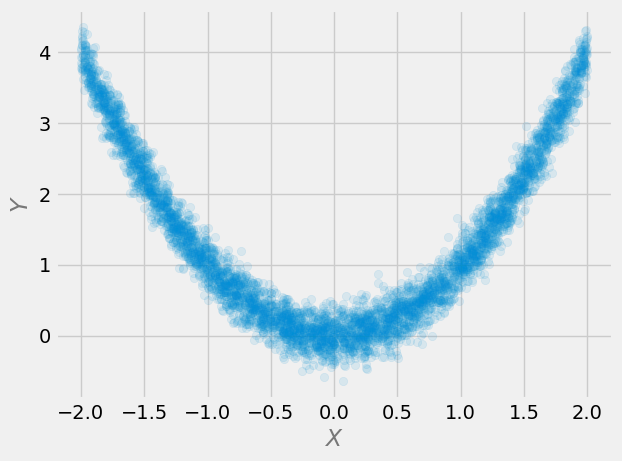

In [71]:
plt.scatter(x, y, alpha=.1)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
plt.show()

In [72]:
# Correlation coefficient
stats.spearmanr(x, y)

SignificanceResult(statistic=-0.017571125214845006, pvalue=0.21414381254206408)

# Chapter 04

In this chapter we focus on graphical models for causal inference. We start with a refresher on graphs. 

In [73]:
import graphviz

In [74]:
nodes = ['A', 'B', 'C', 'D']

In [75]:
# Define graphs
graphs = {
    
    'DAG': {
        'graph': graphviz.Digraph(format='png'),
        'edges': ['AB', 'BC', 'AD', 'DC']
    },
    
    'DCG': {
        'graph': graphviz.Digraph(format='png'),
        'edges': ['AB', 'AD', 'BB', 'BC', 'DC', 'CA']
    },
    
    'Undirected': {
        'graph': graphviz.Graph(format='png'),
        'edges': ['AB', 'BC', 'AD', 'DC']
    }, 
    
    'Fully connected': {
        'graph': graphviz.Graph(format='png'),
        'edges': ['AB', 'AC', 'AD', 'BC', 'BD', 'CD']
    },
    
    'Partially connected': {
        'graph': graphviz.Graph(format='png'),
        'edges': ['AB', 'AC', 'BC']
    }
}


# Iterate over graphs and render
for name, graph in graphs.items():
    
    [graph['graph'].node(n) for n in nodes]
    graph['graph'].edges(graph['edges'])
    
    graph['graph'].render(f'img/ch_04_graph_{name}')

### Adjacency matrices

$$\Large \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}$$

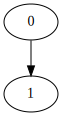

In [76]:
graph = graphviz.Digraph(format='png')

nodes = ['0', '1']

edges = ['01']

[graph.node(n) for n in nodes]
graph.edges(edges)

graph.render(f'img/ch_04_graph_adj_00')

graph

$$\Large \begin{bmatrix} 0 & 1 & 0 \\ 0 & 0 & 0 \\ 1 & 1 & 0 \end{bmatrix}$$

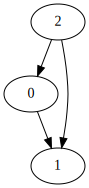

In [77]:
graph = graphviz.Digraph(format='png')

nodes = ['0', '1', '2']

edges = ['01', '21', '20']

[graph.node(n) for n in nodes]
graph.edges(edges)

graph.render(f'img/ch_04_graph_adj_01')

graph

$$\Large \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 1 & 0 \end{bmatrix}$$

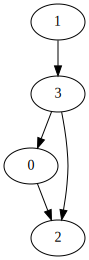

In [78]:
graph = graphviz.Digraph(format='png')

nodes = ['0', '1', '2', '3']

edges = ['02', '13', '32', '30']

[graph.node(n) for n in nodes]
graph.edges(edges)

graph.render(f'img/ch_04_graph_adj_02')

graph

## Graphs in Python wirh the networkx library

In [79]:
import networkx as nx

### Edge list

### GML 

**GML** stands for graph modeling language. 

More on **GML** synatx here: https://github.com/GunterMueller/UNI_PASSAU_FMI_Graph_Drawing/blob/master/GML/gml-technical-report.pdf

In [80]:
# Define the graph
sample_gml = """graph [
directed 1

node [
    id 0
    label "0"
    ]

node [
    id 1
    label "1"
    ]
    
node [
    id 2
    label "2"
    ]


edge [
    source 0
    target 1
    ]
    
edge [
    source 2
    target 1
    ]
]
    
    """

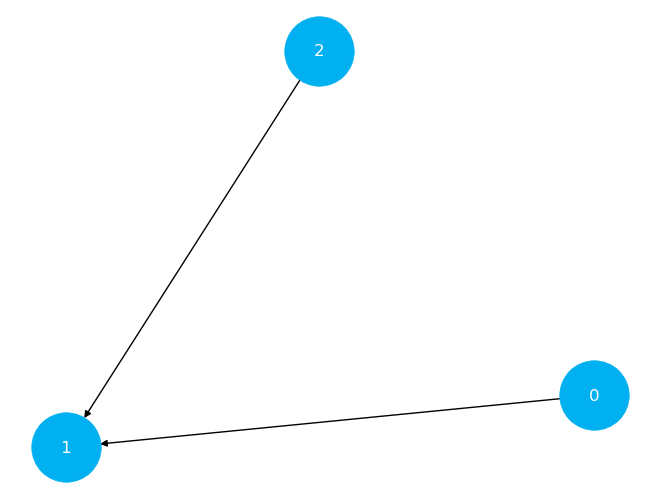

In [83]:
# Get the graph
graph = nx.parse_gml(sample_gml)

# Plot
nx.draw(
    G=graph, 
    with_labels=True,
    node_size=2500,
    node_color=COLORS[0],
    font_color='white'
)

### Adjacency matrix

In [86]:
# Define the matrix
adj_matrix = np.array([
    [0, 1, 0],
    [0, 0, 0],
    [0, 1, 0]
])

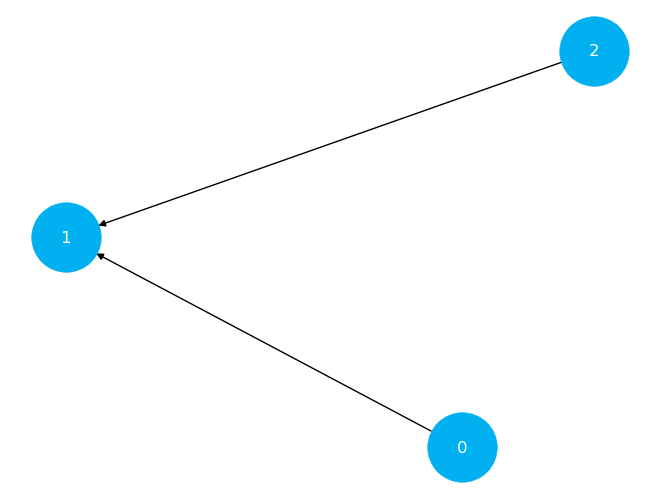

In [87]:
# Get the graph
#graph = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Plot
nx.draw(
    G=graph, 
    with_labels=True,
    node_size=2500,
    node_color=COLORS[0],
    font_color='white'
)

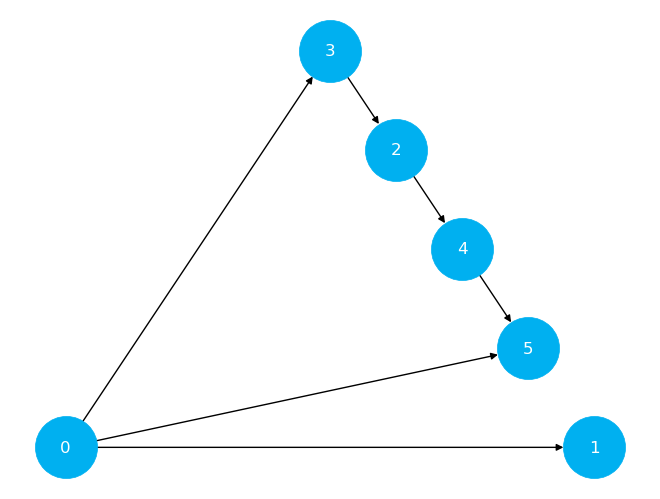

In [88]:
# Define the matrix
adj_matrix = np.array([
    [0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0],
])

# Get the graph
#graph = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Plot
nx.draw(
    G=graph, 
    with_labels=True,
    node_size=2000,
    node_color=COLORS[0],
    font_color='white',
    pos=nx.planar_layout(graph)
)

# Chapter 05

This chapter introduces the concept of mapping between distributions and graphs. We define and demonstrate basic graphical structures and (briefly) talk about statistical and graphical independence. Finally, we implement regression models to show how different graphical structures manifest themselves in statistical (in)dependencies.

In [89]:
from itertools import combinations

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [90]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## Visualizations

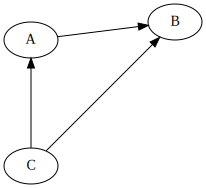

In [91]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'B', 'C']
positions = ['0,2.75!', '2,3!', '0,1!']

edges = ['AB', 'CB', 'CA']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_05_markov_01')

graph

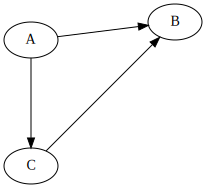

In [92]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'B', 'C']
positions = ['0,2.75!', '2,3!', '0,1!']

edges = ['AB', 'CB', 'AC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_05_markov_02')

graph

## Causal graphs and independence

In [93]:
NOISE_LEVEL = .2
N_SAMPLES = 1000

### A chain: `A -> B -> C`

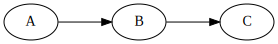

In [94]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'B', 'C']
positions = ['0,0!', '1.5,0!', '3,0!']

edges = ['AB', 'BC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_05_chain_00')

graph

In [95]:
# Generate the data
a = np.random.randn(N_SAMPLES) 
b = a + NOISE_LEVEL*np.random.randn(N_SAMPLES) 
c = b + NOISE_LEVEL*np.random.randn(N_SAMPLES) 

# Get combinations
combs = list(combinations([('a', a), ('b', b), ('c', c)], 2))

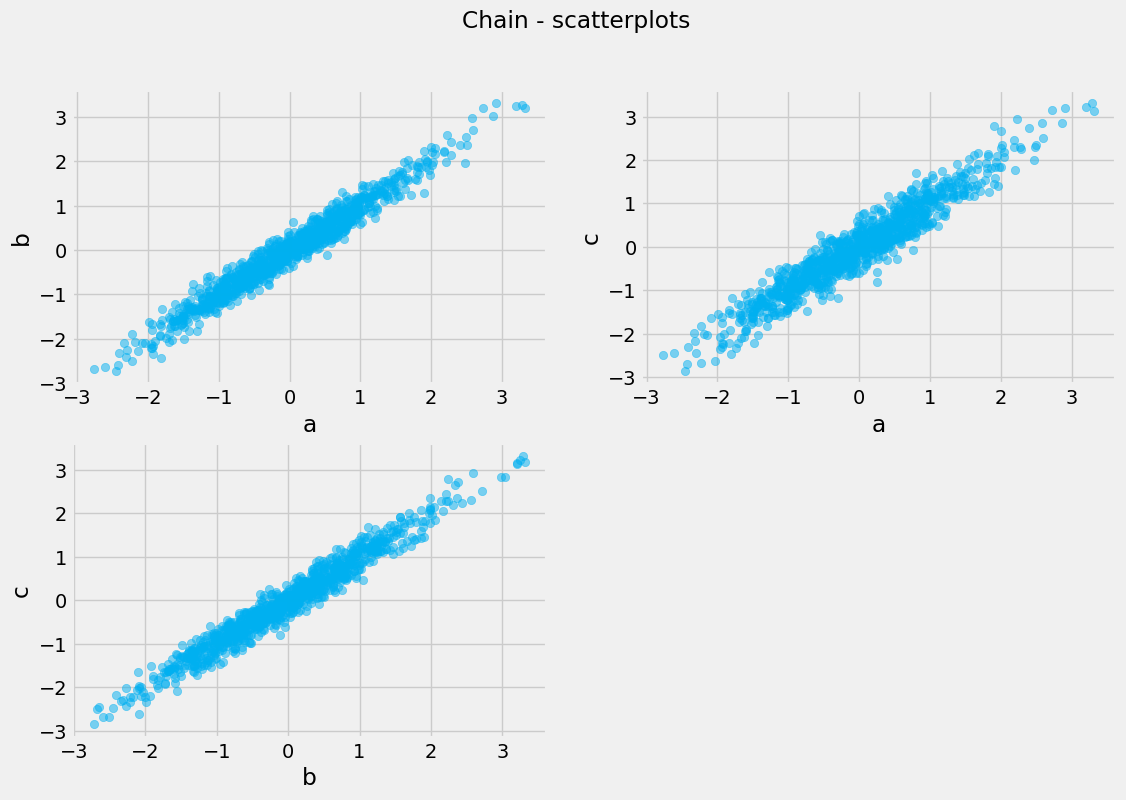

In [96]:
# Plot
plt.figure(figsize=(12, 8))

for i, comb in enumerate(combs):
    key_1, key_2 = comb[0][0], comb[1][0]
    
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(comb[0][1], comb[1][1], alpha=.5, color=COLORS[0])
    plt.xlabel(key_1)
    plt.ylabel(key_2)

plt.suptitle('Chain - scatterplots')
plt.show()

In [97]:
X = pd.DataFrame(np.vstack([a, b]).T, columns=['A', 'B'])
X = sm.add_constant(X, prepend=True)

model = sm.OLS(c, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.159e+04
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:23:35   Log-Likelihood:                 170.48
No. Observations:                1000   AIC:                            -335.0
Df Residuals:                     997   BIC:                            -320.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.006     -0.123      0.9

### A fork: `A <- B -> C`

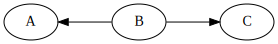

In [98]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'B', 'C']
positions = ['0,0!', '1.5,0!', '3,0!']

edges = ['BA', 'BC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_05_fork_00')

graph

In [99]:
# Generate the data
b = np.random.randn(N_SAMPLES) 
a = b + NOISE_LEVEL*np.random.randn(N_SAMPLES) 
c = b + NOISE_LEVEL*np.random.randn(N_SAMPLES) 

# Get combinations
combs = list(combinations([('a', a), ('b', b), ('c', c)], 2))

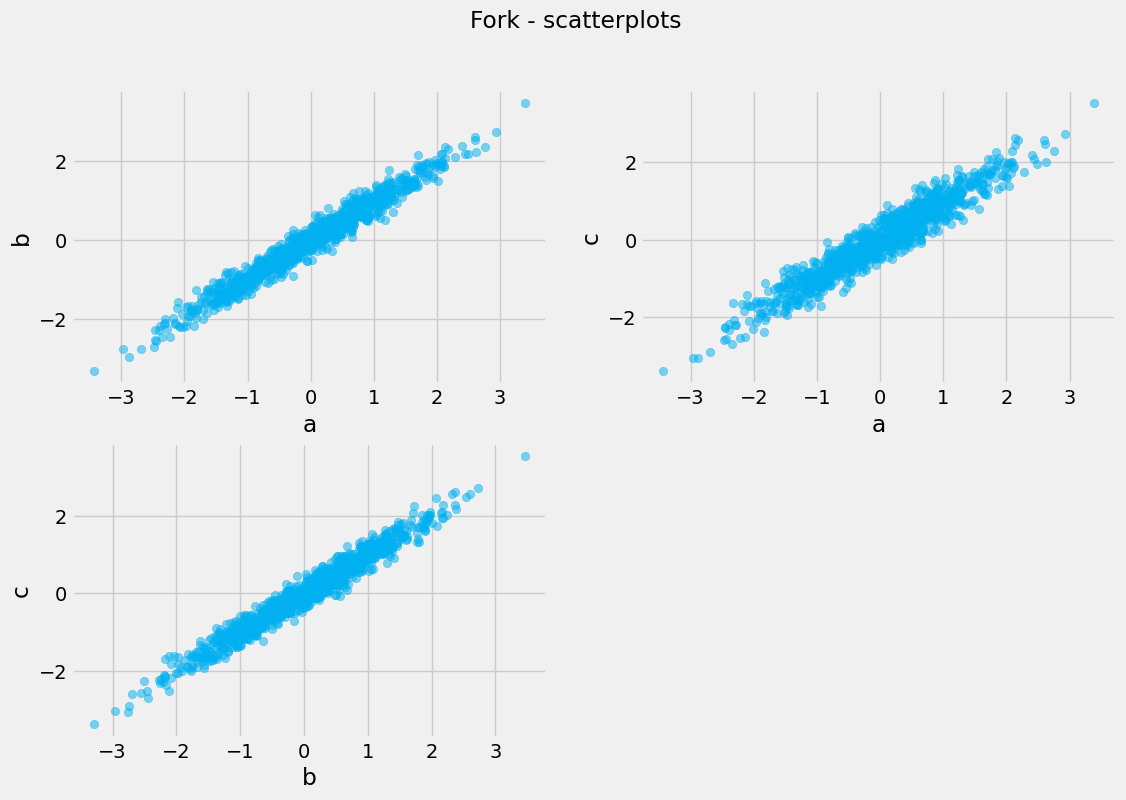

In [100]:
# Plot
plt.figure(figsize=(12, 8))

for i, comb in enumerate(combs):
    key_1, key_2 = comb[0][0], comb[1][0]
    
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(comb[0][1], comb[1][1], alpha=.5, color=COLORS[0])
    plt.xlabel(key_1)
    plt.ylabel(key_2)

plt.suptitle('Fork - scatterplots')
plt.show()

In [101]:
X = pd.DataFrame(np.vstack([a, b]).T, columns=['A', 'B'])
X = sm.add_constant(X, prepend=True)

model = sm.OLS(c, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.191e+04
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:24:34   Log-Likelihood:                 178.54
No. Observations:                1000   AIC:                            -351.1
Df Residuals:                     997   BIC:                            -336.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.006     -0.259      0.7

### A collider: `A -> B <- C`

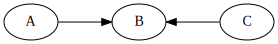

In [102]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'B', 'C']
positions = ['0,0!', '1.5,0!', '3,0!']

edges = ['AB', 'CB']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_05_collider_00')

graph

In [103]:
# Generate the data
a = np.random.randn(N_SAMPLES) 
c = np.random.randn(N_SAMPLES) 
b = a + c + NOISE_LEVEL*np.random.randn(N_SAMPLES) 

# Get combinations
combs = list(combinations([('a', a), ('b', b), ('c', c)], 2))

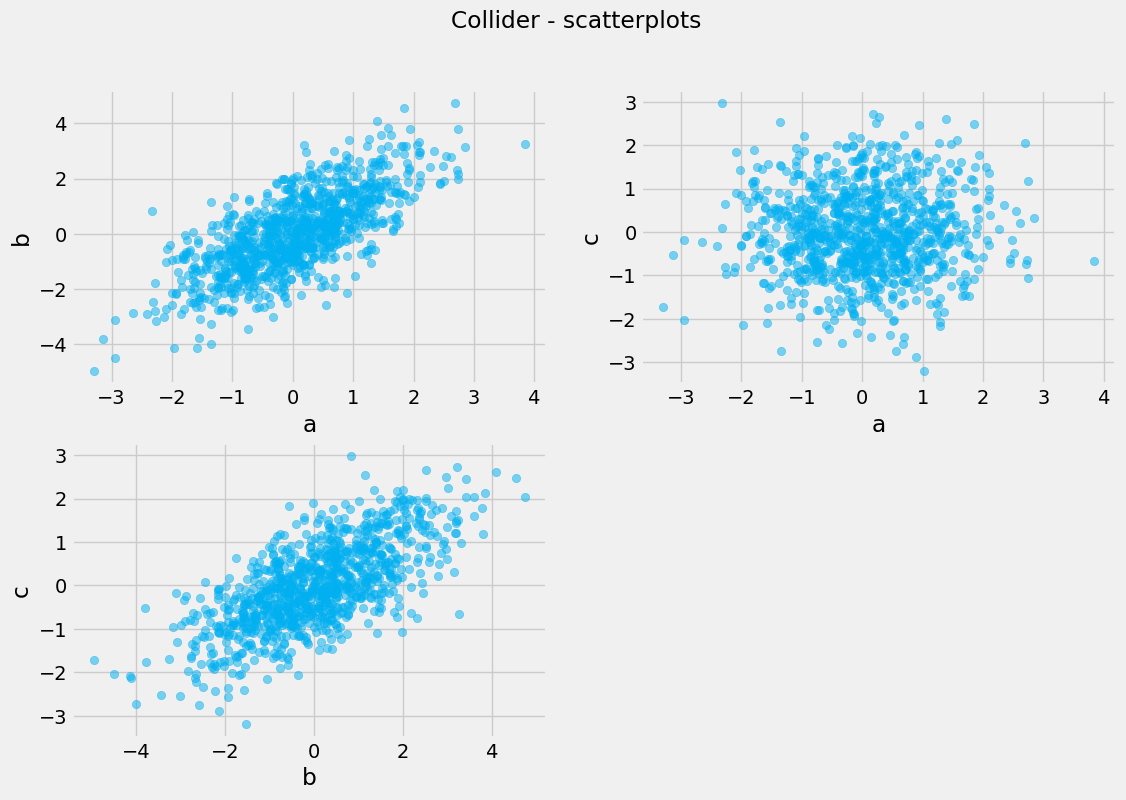

In [104]:
# Plot
plt.figure(figsize=(12, 8))

for i, comb in enumerate(combs):
    key_1, key_2 = comb[0][0], comb[1][0]
    
    
    plt.subplot(2, 2, i + 1)
    plt.scatter(comb[0][1], comb[1][1], alpha=.5, color=COLORS[0])
    plt.xlabel(key_1)
    plt.ylabel(key_2)

plt.suptitle('Collider - scatterplots')
plt.show()

In [105]:
X = pd.DataFrame(np.vstack([a, b]).T, columns=['A', 'B'])
X = sm.add_constant(X, prepend=True)

model = sm.OLS(c, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.209e+04
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:25:31   Log-Likelihood:                 219.15
No. Observations:                1000   AIC:                            -432.3
Df Residuals:                     997   BIC:                            -417.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.006     -0.485      0.6

## Causal models with DoWhy

In [108]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [109]:
dowhy.__version__

'0.8'

In [110]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In this chapter we focus on the full four-steps causal inference process. 

### Generate the data

In [111]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [112]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

In [113]:
df

,X,Z,Y
0,2.485617,-2.207780,-0.935699
1,9.196313,-5.712621,-3.582653
2,2.906669,-1.925779,-0.808285
3,4.757706,-2.124215,0.201351
4,1.472985,-0.874563,-0.477487
...,...,...,...
995,3.941898,-2.560232,-1.349227
996,12.050938,-7.759077,-4.888268
997,5.165607,-2.998211,-1.069006
998,11.943465,-7.225460,-4.059762


### Step 1: Modeling the problem

#### Step 1.1 - Define the graph - `GML`

In [114]:
# Create the graph describing the causal structure
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

#### Step 1.2 - define the DoWhy model

In [115]:
# With graph
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

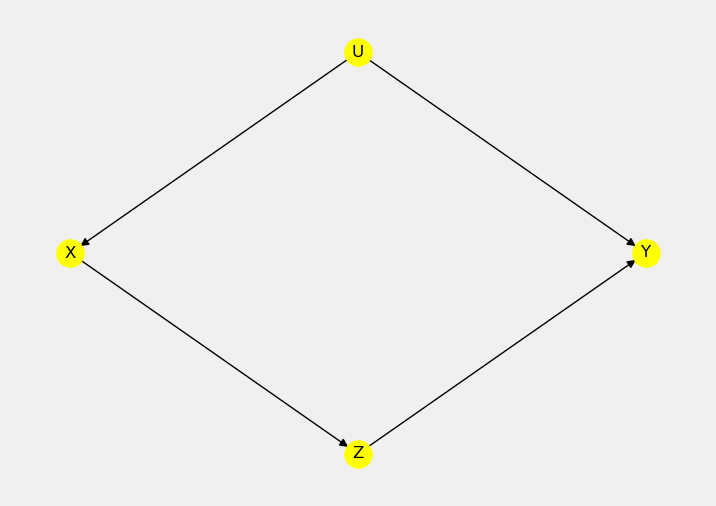

In [116]:
model.view_model()

### Step 2: Identify the estimand

In [117]:
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



### Step 3: Estimate the causal effect

#### Example 1 - Linear Regression

In [118]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

two_stage_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
Estimate of causal effect (linear regression): -0.411111257096465


/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


### Step 4: Run refutation tests

In [119]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '

/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/antoinecornuejols/NewAnaConda_v1/anaconda3/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as po

In [120]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.411111257096465
New effect:-0.41096830858856004
p value:0.8999999999999999



## Full example

### Data

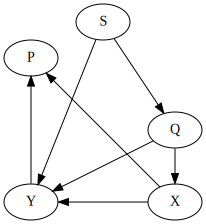

In [121]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_07_full_example')

graph

In [122]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [124]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [125]:
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [126]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

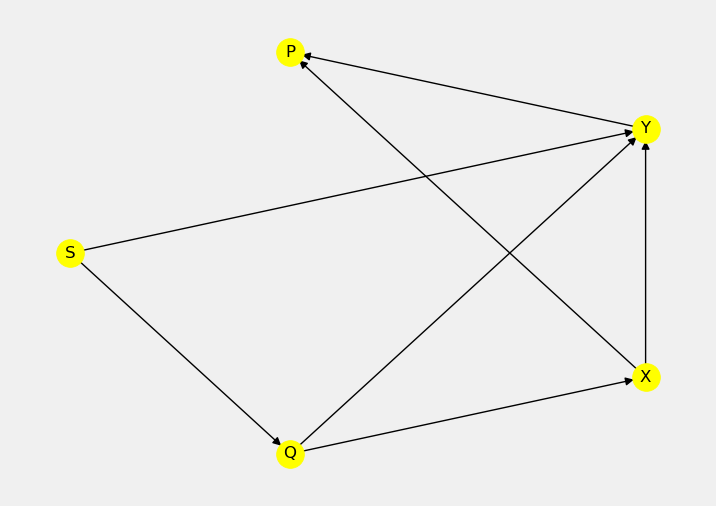

In [127]:
model.view_model()

In [128]:
# Get the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Chapter 09



In [129]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [130]:
dowhy.__version__

'0.8'

In [131]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## Matching

### Read the data

In [132]:
earnings_data = pd.read_csv(r'./data/ml_earnings.csv')

In [133]:
earnings_data.shape

In [134]:
earnings_data.head()

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [135]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [136]:
# Compute naive estimate 
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

### Define the graph

In [137]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [138]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)


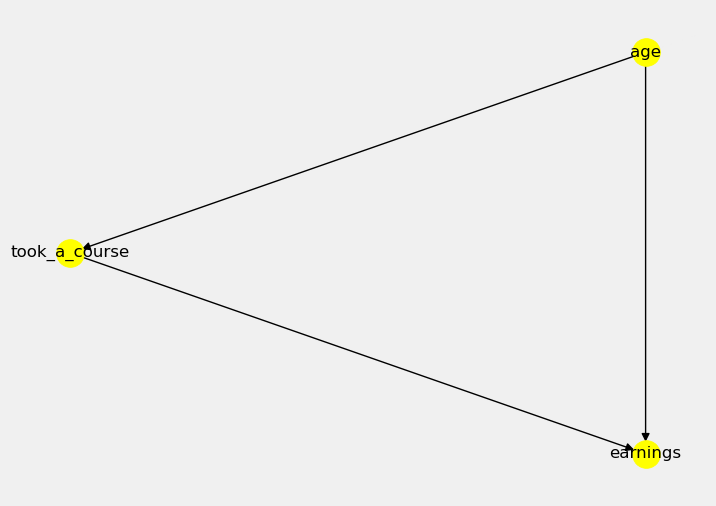

In [139]:
model.view_model()

### Get the estimand

In [140]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [141]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


In [142]:
estimate.value

In [143]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [144]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10333.75
New effect:10272.1112
p value:0.6200000000000001

